Historia completa

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet

In [4]:
regalos = pd.read_csv('regalos.csv', index_col=0)
regalos

,0,1,2,3
0,9,8,8,11
1,6,9,11,10
2,16,4,9,7
3,18,4,8,6
4,5,10,14,7
...,...,...,...,...
360,10,10,8,8
361,10,5,11,10
362,9,11,11,5
363,13,8,10,5


In [5]:
regalos.sum()

,0
0,3373
1,3269
2,3229
3,3269


In [6]:
def update_alpha(alpha, data, lambda_):
    cant_dias = data.shape[0]
    new_alpha = np.zeros_like(alpha)

    for j in range(cant_dias):
        prev_day = (j - 1) % cant_dias
        next_day = (j + 1) % cant_dias

        new_alpha[j] = lambda_ * (alpha[prev_day] / 2 + alpha[next_day] / 2) + data.iloc[j]

    return new_alpha

def loopy_belief_propagation(datos, l, max_iter=1000, tol=1e-20):
    alfa = np.ones((datos.shape))

    for it in range(max_iter):
        alfa_nuevo = update_alpha(alfa, datos, l)
        if np.all(np.abs(alfa_nuevo - alfa) < tol):
            print(f"Convergencia en la iteración {it}")
            break
        alfa = alfa_nuevo

    return alfa

In [7]:
def optimizar_lambda(datos, valslambda):
    mejor_l = None
    mejor_alfa = None
    mejor_score = float("inf")

    for l in valslambda:
        alfa_actual = loopy_belief_propagation(datos, l)
        score = np.sum((alfa_actual - datos.values) ** 2)  # Error cuadrático

        if score < mejor_score:
            mejor_score = score
            mejor_l = l
            mejor_alfa = alfa_actual

    print(f"Mejor lambda encontrado: {mejor_l}")
    return mejor_l, mejor_alfa

In [9]:
lambdas = np.linspace(0.1, 0.9, 10)
best_lambda, best_alpha = optimizar_lambda(regalos, lambdas)

Convergencia en la iteración 19
Convergencia en la iteración 26
Convergencia en la iteración 33
Convergencia en la iteración 41
Convergencia en la iteración 54
Convergencia en la iteración 66
Convergencia en la iteración 87
Convergencia en la iteración 120
Convergencia en la iteración 184
Convergencia en la iteración 354
Mejor lambda encontrado: 0.1


In [10]:
print(f"El mejor lambda es: {best_lambda} y el mejor alfa es {best_alpha} ")

El mejor lambda es: 0.1 y el mejor alfa es [[ 9.92814213  9.02978981  8.84652394 12.19554413]
 [ 7.36279426  9.68762882 11.94532487 11.00425206]
 [17.32774302  4.72278651 10.05997343  7.88949705]
 ...
 [10.25640649 11.76297353 12.14595116  5.83466882]
 [14.07282274  9.13355704 10.85655526  5.93706496]
 [11.20004824 10.90816734  4.98515396 12.90663045]] 


In [11]:
def calculo_probas(alpha):
    probas = alpha / alpha.sum(axis=1, keepdims=True)
    elecciones = []

    for dias in probas:
        # Si elijo la caja con más probabilidad, la pista me podría apuntar a la que ya sabía que tenía menos probabilidad
        # Si elijo la caja con menos probabildad, la pista me va a decir que no está en una que no había descartado
        eleccion = np.argmin(dias)
        elecciones.append(eleccion)

    return probas, elecciones

In [12]:
probas, elecciones = calculo_probas(best_alpha)

In [13]:
resultado = pd.DataFrame(probas, columns=regalos.columns)
resultado["caja elegida"] = elecciones
resultado.to_csv("resultado_inferencia.csv", index=False)

In [18]:
def plot_probabilities(probabilities):
    num_days, num_boxes = probabilities.shape
    days = np.arange(1, num_days + 1)

    plt.figure(figsize=(12, 6))
    for i in range(num_boxes):
        plt.plot(days, probabilities[:, i], label=f"Caja {i}")

    plt.xlabel("Día")
    plt.ylabel("Probabilidad estimada")
    plt.title("Estimación de probabilidades de la posición del regalo")
    plt.legend()
    plt.grid(True)
    plt.show()


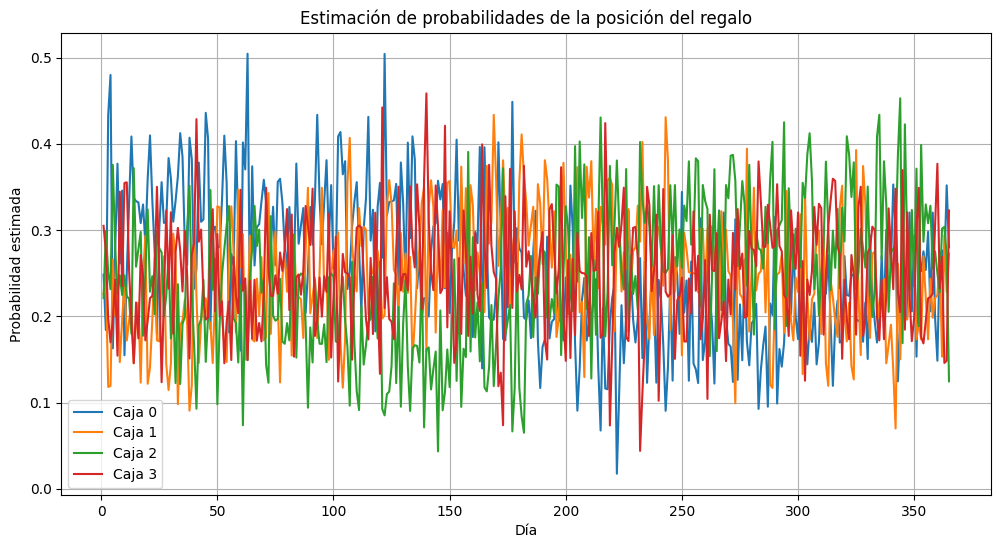

In [19]:
plot_probabilities(probas)

In [20]:
def plot_distance(probabilities, observations):
    num_days, num_boxes = probabilities.shape
    days = np.arange(1, num_days + 1)

    observed_frequencies = observations / 36

    distances = np.abs(probabilities - observed_frequencies.values)

    plt.figure(figsize=(12, 6))
    for i in range(num_boxes):
        plt.plot(days, distances[:, i], label=f"Distancia Caja {i}")

    plt.xlabel("Día")
    plt.ylabel("Distancia entre probabilidades y frecuencias observadas")
    plt.title("Distancia entre probabilidades calculadas y observaciones reales")
    plt.legend()
    plt.grid(True)
    plt.show()


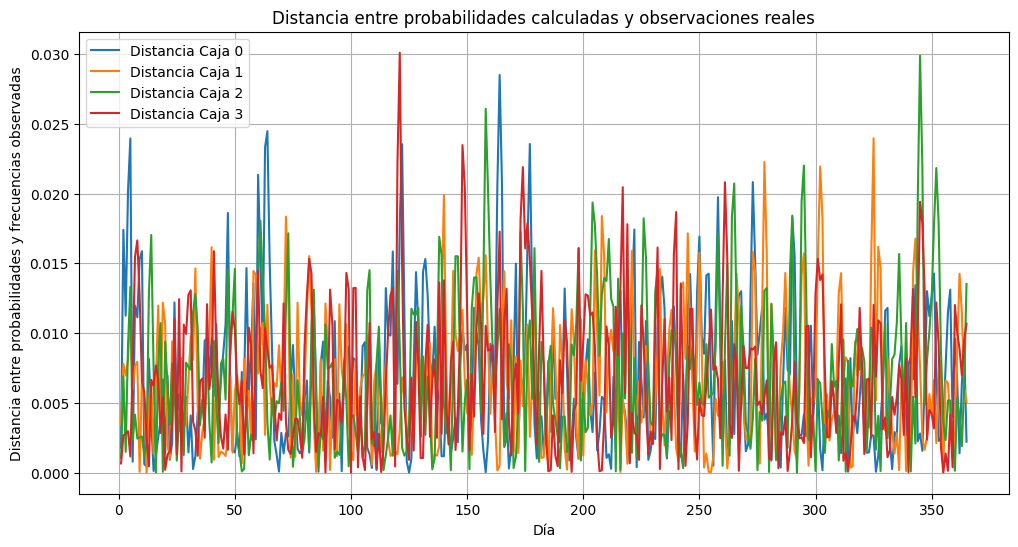

In [21]:
plot_distance(probas, regalos)